# NLP work with PySpark
## Using the DocNLI Dataset for Document-Level Natural Language Inference (NLI)
### Created by: Keerthana Goka, and Kunal Malhan

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,477 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,424 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,615 kB]
Fetch

In [ ]:
from pyspark.sql.functions import col, count, lower, udf
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql.types import StringType, FloatType
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

import numpy as np
import re

In [ ]:
from pyspark.sql import DataFrame, SparkSession
spark= SparkSession \
       .builder \
       .appName("DocNLI Dataset for Document-Level Natural Language Inference (NLI)") \
       .config("spark.driver.memory", "6g") \
       .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Exploration

## 1.1. Download the DocNLI dataset and load it into your environment

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/NLP/DocNLI_dataset/'

In [ ]:
df_dev   = spark.read.json(data_path + 'dev.json')
df_test  = spark.read.json(data_path + 'test.json')
df_train = spark.read.json(data_path + 'dev.json')

In [ ]:
df_train.show()

+--------------------+--------------------+--------------+--------------------+
|     _corrupt_record|          hypothesis|         label|             premise|
+--------------------+--------------------+--------------+--------------------+
|[{"premise": "US ...|                NULL|          NULL|                NULL|
|                NULL|Hurricane Andrew ...|    entailment|US CITIES along t...|
|                NULL|American insurers...|    entailment|US CITIES along t...|
|                NULL|US cities along t...|not_entailment|US CITIES along t...|
|                NULL|US cities along G...|not_entailment|US CITIES along t...|
|                NULL|US cities along t...|not_entailment|US CITIES along t...|
|                NULL|US cities along t...|not_entailment|US CITIES along t...|
|                NULL|US cities along t...|not_entailment|US CITIES along t...|
|                NULL|US cities along t...|not_entailment|US CITIES along t...|
|                NULL|US systems along .

In [ ]:
df_train.tail(5)

[Row(_corrupt_record=None, hypothesis='The director says inflation needs to be higher.', label='not_entailment', premise='But Rajeev Dhawan, director of the Economic Forecasting Center at Georgia State University, says the main issue ahead is higher inflation.'),
 Row(_corrupt_record=None, hypothesis='It is toxic to the environment ', label='not_entailment', premise='Humic acids are complex organic molecules formed by the breakdown of organic matter in the soil. They are not considered to be fertilizers, but soil enhancers and improvers.'),
 Row(_corrupt_record=None, hypothesis='The Doran Armed Forces carried out the action', label='not_entailment', premise='The human rights promotion and protection secretariat of the FMLN strongly condemns the massacre of five Spanish-born Jesuit priests, and three Salvadoran citizens, carried out by the Salvadoran Armed Forces Soldiers.'),
 Row(_corrupt_record=None, hypothesis='The ship sunk in the Atlantic.', label='not_entailment', premise='The shi

## 1.2. Explore the structure of the dataset

#### Number of instances (sentence pairs) in the dataset

In [ ]:
df_train.count()

234258

### 1.2.1 Checking Nulls in each column

In [ ]:
from pyspark.sql.functions import isnull, when, count, col
df_train.select([count(when(isnull(c), c)).alias(c) for c in df_train.columns]).show()

+---------------+----------+-----+-------+
|_corrupt_record|hypothesis|label|premise|
+---------------+----------+-----+-------+
|         234257|         1|    1|      1|
+---------------+----------+-----+-------+



### 1.2.2. Drop the row where label is null

In [ ]:
df_train = df_train.dropna(subset=["label"])

### 1.2.3 Rechecking Nulls in each column

In [ ]:
from pyspark.sql.functions import isnull, when, count, col
df_train.select([count(when(isnull(c), c)).alias(c) for c in df_train.columns]).show()

+---------------+----------+-----+-------+
|_corrupt_record|hypothesis|label|premise|
+---------------+----------+-----+-------+
|         234257|         0|    0|      0|
+---------------+----------+-----+-------+



## 1.3. Identify and describe the main features/columns in the dataset

#### Print Distinct values for _corrupt_record

In [ ]:
df_train.cache()
df_train.select(col("_corrupt_record")).distinct().show()

+---------------+
|_corrupt_record|
+---------------+
|           NULL|
+---------------+



#### Print total number of distinct hypothesis

In [ ]:
df_train.select(col("hypothesis")).distinct().count()

135288

#### Print Distinct values for label

In [ ]:
df_train.select(col("label")).distinct().show()

+--------------+
|         label|
+--------------+
|    entailment|
|not_entailment|
+--------------+



#### Print total number of distinct premise

In [ ]:
df_train.select(col("premise")).distinct().count()

127927

## 1.4. Visualize the distribution of the labels

In [ ]:
label_distribution = df_train.groupBy("label").count()
label_distribution.show()

+--------------+------+
|         label| count|
+--------------+------+
|    entailment| 28889|
|not_entailment|205368|
+--------------+------+



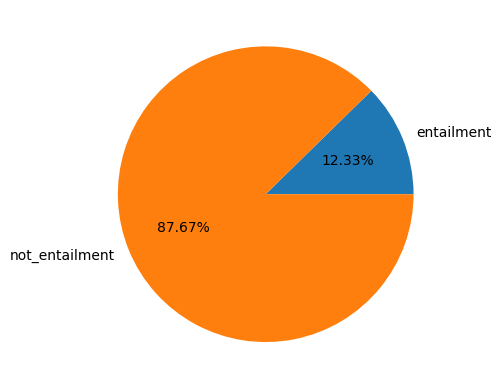

In [ ]:
pd_label_distribution = label_distribution.toPandas()

plt.pie(pd_label_distribution['count'], labels=pd_label_distribution['label'], autopct='%.2f%%')
plt.show()

<font color='blue' size='5'><b>Insights:</b> There was only 1 record with missing entailment and non-entailment information (neutral), which was dropped. Overall, entailment and contradiction are present in almost equal parts.</font>

# 2. Preprocessing

## 2.1. Perform basic text preprocessing steps [For premise columns]

### 2.1.1. Lowercasing

In [ ]:
df_train_clean  = df_train.withColumn("premise_lower", lower(df_train["premise"]))
df_train_clean.select("premise", "premise_lower").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.2. Removing punctuations and non-alphabets

In [ ]:
@udf(StringType())
def clean_word(word):
    tempText = re.sub('[^a-zA-Z]', ' ', word).lower()
    return " ".join(tempText.split())

df_train_clean = df_train_clean.withColumn("premise_lower_clean", clean_word(col("premise_lower")))
df_train_clean.select("premise_lower", "premise_lower_clean").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.3. Tokenization

In [ ]:
tokenizer       = Tokenizer(inputCol="premise_lower_clean", outputCol="premise_words")
df_train_clean  = tokenizer.transform(df_train_clean)
df_train_clean.select("premise_lower_clean", "premise_words").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.4. Removing stop words

In [ ]:
remover         = StopWordsRemover(inputCol="premise_words", outputCol="premise_words_clean")
df_train_clean  = remover.transform(df_train_clean)
df_train_clean.select("premise_words", "premise_words_clean").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.5. Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
@udf
def lemmatize_custom(words):
    lemmatizer_tokens = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatizer_tokens)

df_train_clean = df_train_clean.withColumn("premise_words_clean_lemma", lemmatize_custom(col("premise_words_clean")))
tokenizer2 = Tokenizer(inputCol="premise_words_clean_lemma", outputCol="premise_words_clean_lemma_array")
df_train_clean = tokenizer2.transform(df_train_clean)
df_train_clean.select("premise_words_clean", "premise_words_clean_lemma_array").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.6. Showing a sample of the transformed data

In [ ]:
df_train_clean.select("premise", "premise_lower", "premise_lower_clean", "premise_words", "premise_words_clean",
                      "premise_words_clean_lemma_array").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 2.2. Perform basic text preprocessing steps [For hypothesis columns]

### 2.2.1. Lowercasing

In [ ]:
df_train_clean  = df_train_clean.withColumn("hypothesis_lower", lower(df_train["hypothesis"]))
df_train_clean.select("hypothesis", "hypothesis_lower").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2.2. Removing punctuations and non-alphabets

In [ ]:
@udf(StringType())
def clean_word(word):
    tempText = re.sub('[^a-zA-Z]', ' ', word).lower()
    return " ".join(tempText.split())

df_train_clean = df_train_clean.withColumn("hypothesis_lower_clean", clean_word(col("hypothesis_lower")))
df_train_clean.select("hypothesis_lower", "hypothesis_lower_clean").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2.3. Tokenization

In [ ]:
tokenizer       = Tokenizer(inputCol="hypothesis_lower_clean", outputCol="hypothesis_words")
df_train_clean  = tokenizer.transform(df_train_clean)
df_train_clean.select("hypothesis_lower_clean", "hypothesis_words").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2.4. Removing stop words

In [ ]:
remover         = StopWordsRemover(inputCol="hypothesis_words", outputCol="hypothesis_words_clean")
df_train_clean  = remover.transform(df_train_clean)
df_train_clean.select("hypothesis_words", "hypothesis_words_clean").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2.5. Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
@udf
def lemmatize_custom(words):
    lemmatizer_tokens = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatizer_tokens)

df_train_clean = df_train_clean.withColumn("hypothesis_words_clean_lemma", lemmatize_custom(col("hypothesis_words_clean")))
tokenizer2 = Tokenizer(inputCol="hypothesis_words_clean_lemma", outputCol="hypothesis_words_clean_lemma_array")
df_train_clean = tokenizer2.transform(df_train_clean)
df_train_clean.select("hypothesis_words_clean", "hypothesis_words_clean_lemma_array").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.2.6. Showing a sample of the transformed data

In [ ]:
df_train_clean.select("hypothesis", "hypothesis_lower", "hypothesis_lower_clean", "hypothesis_words", "hypothesis_words_clean",
                      "hypothesis_words_clean_lemma_array").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 3. Feature Engineering

## 3.1. Premise

### 3.1.1. CountVectorizer

In [ ]:
CV             = CountVectorizer(inputCol="premise_words_clean_lemma_array", outputCol="premise_words_clean_lemma_CV")
CV_Model       = CV.fit(df_train_clean)
df_CV          = CV_Model.transform(df_train_clean)
df_CV.select("premise_words_clean_lemma_array", "premise_words_clean_lemma_CV").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.1.2. TF-IDF

In [ ]:
idf            = IDF(inputCol="premise_words_clean_lemma_CV", outputCol="premise_words_clean_lemma_IDF")
idf_Mode       = idf.fit(df_CV)
df_tfidf       = idf_Mode.transform(df_CV)
df_tfidf.select("premise_words_clean_lemma_array", "premise_words_clean_lemma_CV", "premise_words_clean_lemma_IDF").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3.2. Hypothesis

### 3.2.1. CountVectorizer

In [ ]:
CV2            = CountVectorizer(inputCol="hypothesis_words_clean_lemma_array", outputCol="hypothesis_words_clean_lemma_CV")
CV_Model2      = CV2.fit(df_tfidf)
df_CV2         = CV_Model2.transform(df_tfidf)
df_CV2.select("hypothesis_words_clean_lemma_array", "hypothesis_words_clean_lemma_CV").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.2.2. TF-IDF

In [ ]:
idf2           = IDF(inputCol="hypothesis_words_clean_lemma_CV", outputCol="hypothesis_words_clean_lemma_IDF")
idf_Model2     = idf2.fit(df_CV2)
df_tfidf2      = idf_Model2.transform(df_CV2)
df_tfidf2.select("hypothesis_words_clean_lemma_array", "hypothesis_words_clean_lemma_CV", "hypothesis_words_clean_lemma_IDF").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.3. Preserve for Modeling

### 3.3.1. Selective Columns

In [ ]:
df_for_lr = df_tfidf2.select("premise", "hypothesis", "premise_words_clean_lemma_IDF",
                             "hypothesis_words_clean_lemma_IDF", "label")

# 4. Modeling

## 4.1. Build a document classification model using Logistic Regression with the TF-IDF features

In [ ]:
indexer   = StringIndexer(inputCol="label", outputCol="label_index")
indexerM  = indexer.fit(df_for_lr)
df_for_lr = indexerM.transform(df_for_lr)

mapping = indexerM.labels
print(mapping)
#df_for_lr.show()

['not_entailment', 'entailment']


In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["premise_words_clean_lemma_IDF", "hypothesis_words_clean_lemma_IDF"],
    outputCol="inputfeatures"
)
df_for_lr = assembler.transform(df_for_lr)

In [ ]:
df_for_lr.show()

+--------------------+--------------------+-----------------------------+--------------------------------+--------------+-----------+--------------------+
|             premise|          hypothesis|premise_words_clean_lemma_IDF|hypothesis_words_clean_lemma_IDF|         label|label_index|       inputfeatures|
+--------------------+--------------------+-----------------------------+--------------------------------+--------------+-----------+--------------------+
|US CITIES along t...|Hurricane Andrew ...|         (133718,[0,1,2,5,...|            (56704,[2,3,4,7,1...|    entailment|        1.0|(190422,[0,1,2,5,...|
|US CITIES along t...|American insurers...|         (133718,[0,1,2,5,...|            (56704,[0,2,7,10,...|    entailment|        1.0|(190422,[0,1,2,5,...|
|US CITIES along t...|US cities along t...|         (133718,[0,1,2,5,...|            (56704,[2,7,10,14...|not_entailment|        0.0|(190422,[0,1,2,5,...|
|US CITIES along t...|US cities along G...|         (133718,[0,1,2,5,.

In [ ]:
logit  = LogisticRegression(featuresCol="inputfeatures", labelCol="label_index")

## 4.2. Split the dataset into training and test sets (e.g., 80/20 split)

In [ ]:
Train_data, Test_data = df_for_lr.randomSplit([0.8, 0.2], seed=42)

## 4.3. Train the model on the training data

In [ ]:
lr_model = logit.fit(Train_data)

## 4.4. Prediction on the test data

In [ ]:
model_predictions = lr_model.transform(Test_data)

In [ ]:
model_predictions.select("premise", "hypothesis", "label_index", "prediction").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4.5. Evaluate performance on the test data

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction")
accuracy  = evaluator.evaluate(model_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(model_predictions, {evaluator.metricName: "weightedPrecision"})
recall    = evaluator.evaluate(model_predictions, {evaluator.metricName: "weightedRecall"})
f1        = evaluator.evaluate(model_predictions, {evaluator.metricName: "f1"})

print(f"Accuracy of model  : {accuracy}")
print(f"Precision of model : {precision}")
print(f"Recall of model    : {recall}")
print(f"F1 Score of model  : {f1}")

Accuracy of model  : 0.8037083030017557
Precision of model : 0.8084688794187948
Recall of model    : 0.8037083030017557
F1 Score of model  : 0.8060522597957613


# 5. Analysis and Reflection

## 5.1. Interpret the model’s performance

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


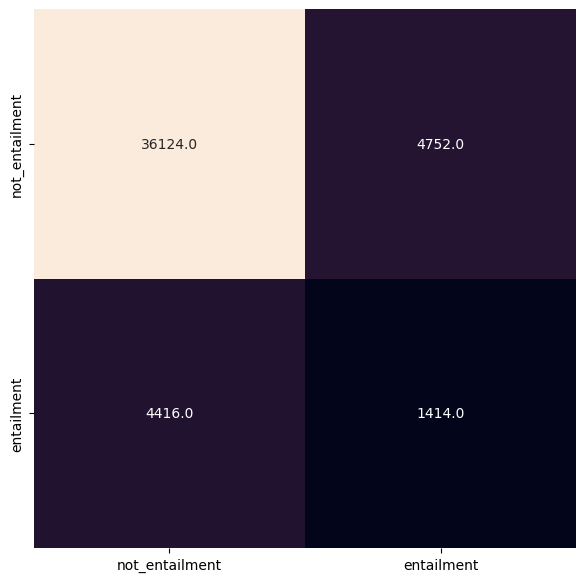

In [ ]:
import seaborn as sns

labels = mapping

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = model_predictions.select(['prediction','label_index']) \
                              .withColumn('label_index', col('label_index') \
                              .cast(FloatType())) \
                              .orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.show()

### Performance Interpretation:
As per Confusion matrix:
#### Not Entailment:
- **True Negatives (36,124)**
- **False Positives (4,752)**

#### Entailment:
- **True Positives (1,414)**
- **False Negatives (4,416)**

The model performs well in predicting `not_entailment` cases; however, it misclassifies `entailment` as `not_entailment` quite often, which lowers the precision and recall.

### Possible Reasons for Poor Performance on Entailment:
1. **Class Imbalance**: As the `not_entailment` class is 87.67% int the dataset, which might have led to the model being biased on predicting `not_entailment`.
2. **Need of better model**: As Document-level NLI is a challenging task and requires understanding deep relationships between sentences or paragraphs, it might need a different model instead of logistic regression.

## 5.2. Challenges arise from performing inference at the document level compared to the sentence level


Document-level inference is more challenging than sentence-level as it has to go beyong understand on a sentense level. It requires to maintain understanding over longer context.It also needs higher conputation and memory requirements. Further, it has to be able to filter irrelevant data and understand the actual contex.

## 5.3. Further improvements or alternative approaches

Pre-trained models are processed using large volumn of dataset (documents) from vareity of domains and can perform better than the current approch. Transformer based pre-trained models can process documents at one instance or at hierarchical level or graph level models can process smaller chunks before providing globle context. These models can be tried for better performance.